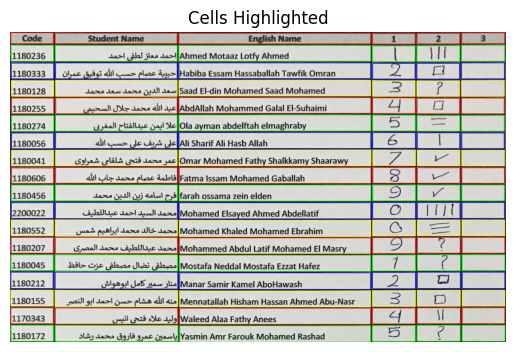

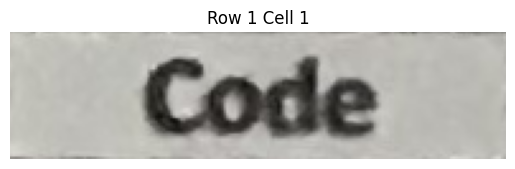

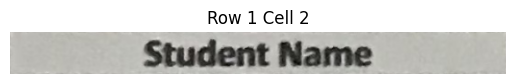

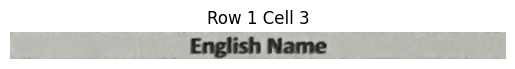

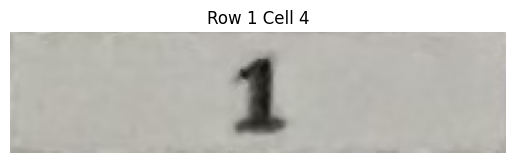

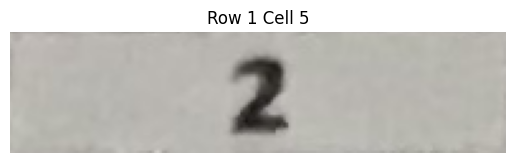

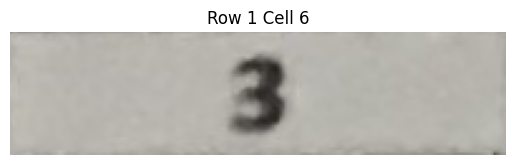

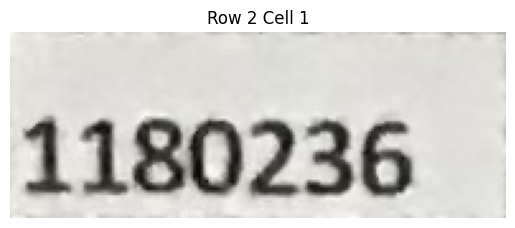

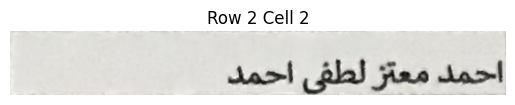

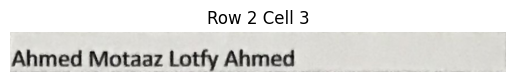

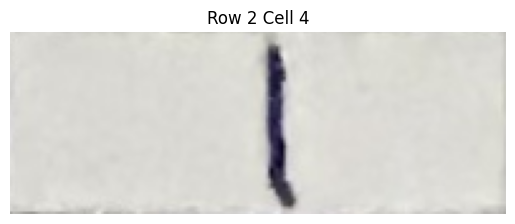

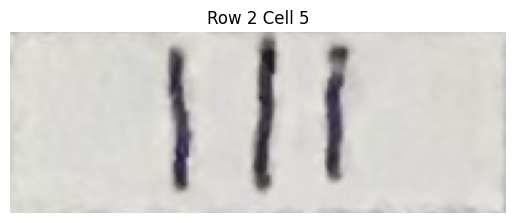

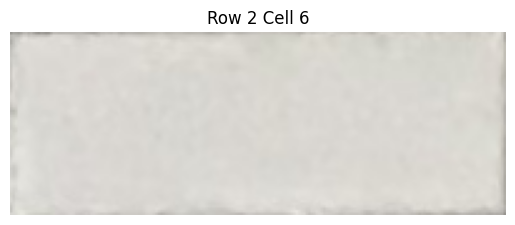

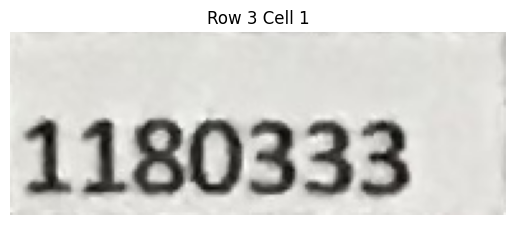

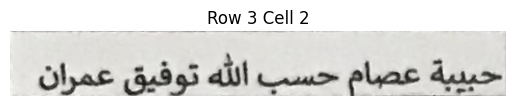

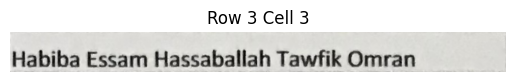

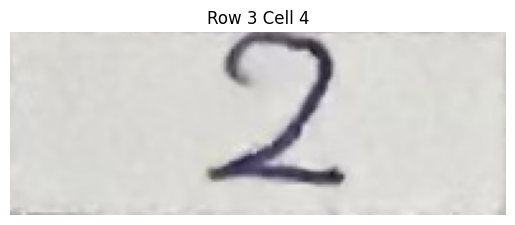

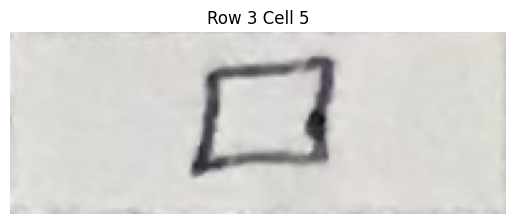

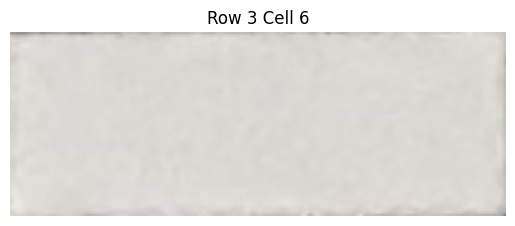

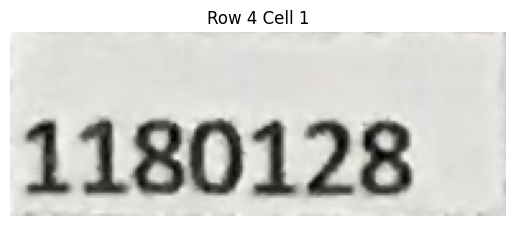

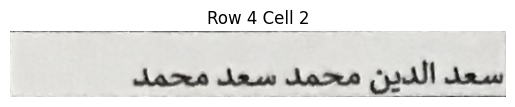

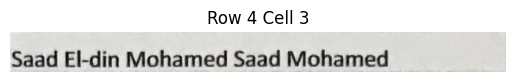

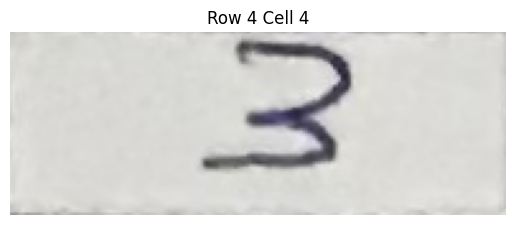

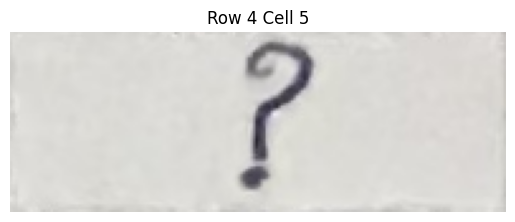

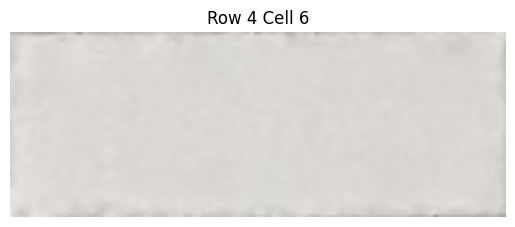

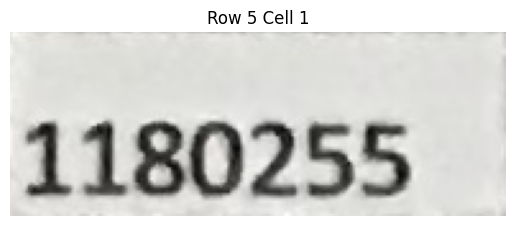

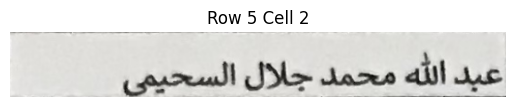

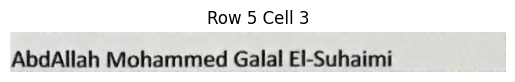

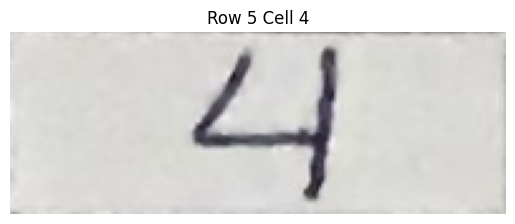

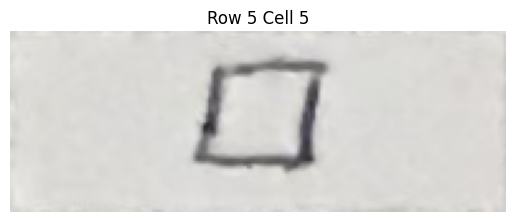

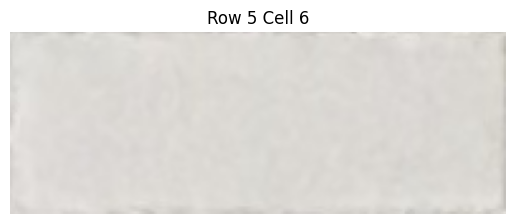

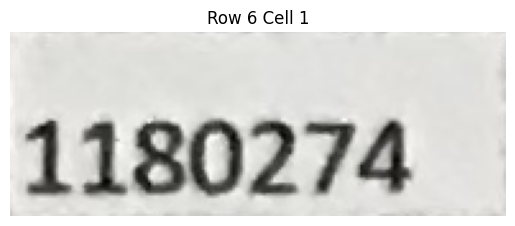

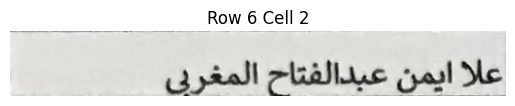

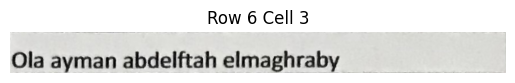

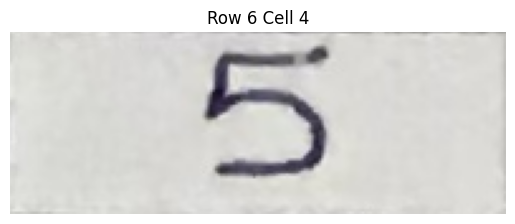

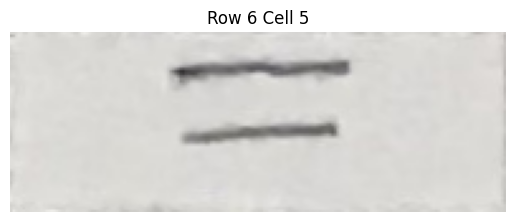

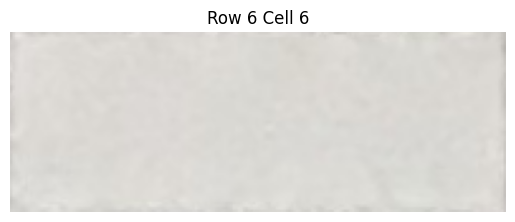

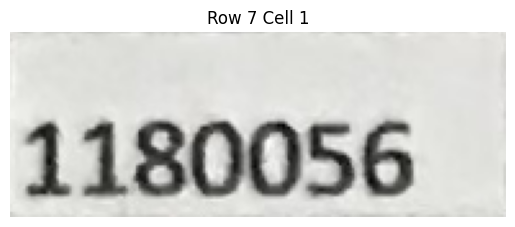

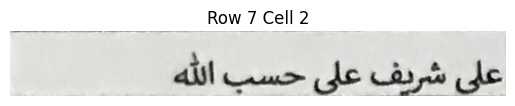

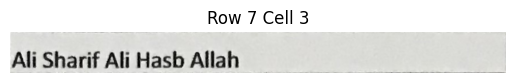

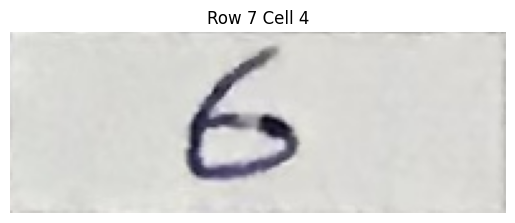

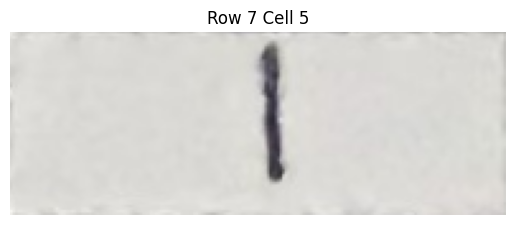

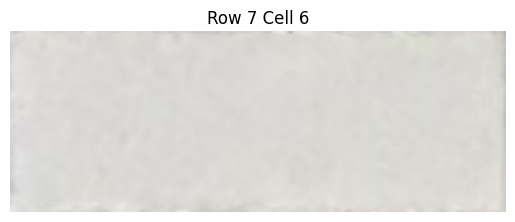

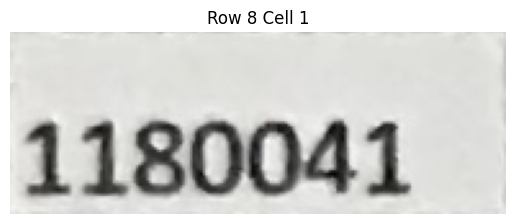

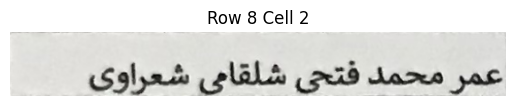

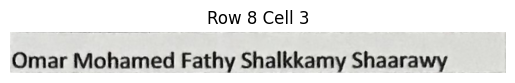

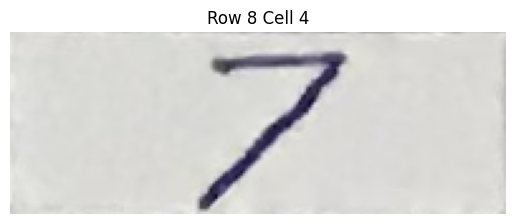

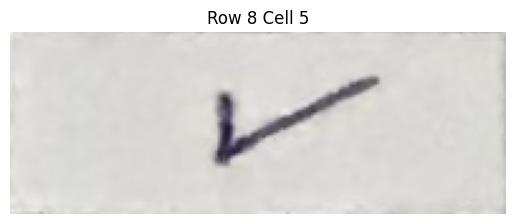

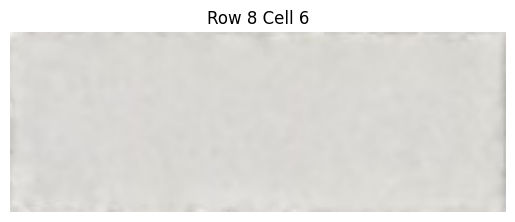

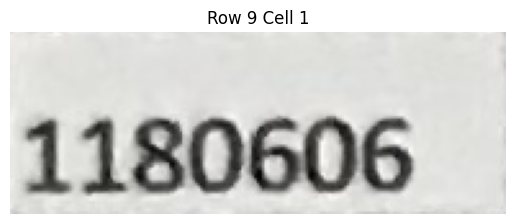

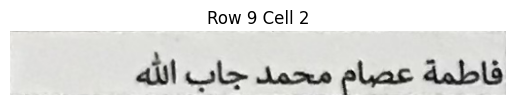

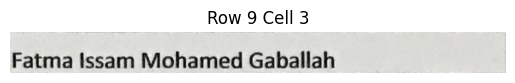

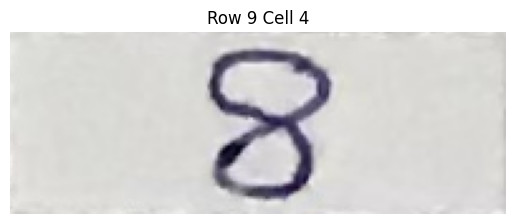

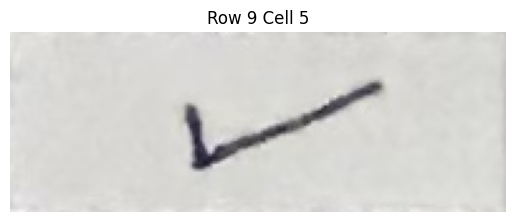

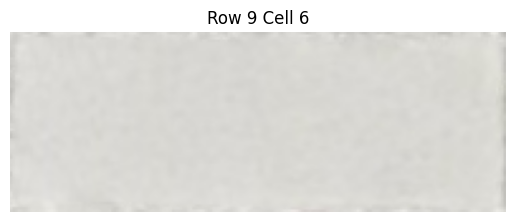

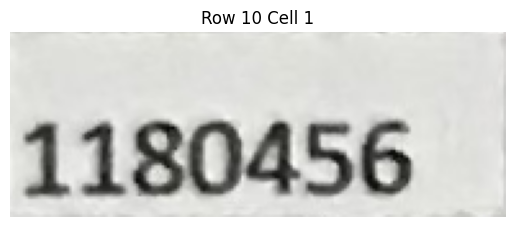

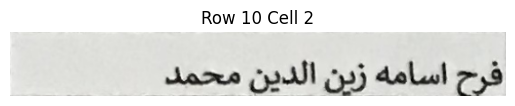

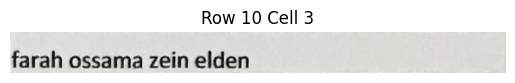

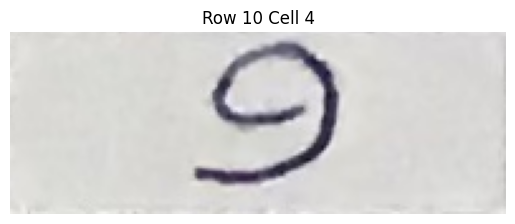

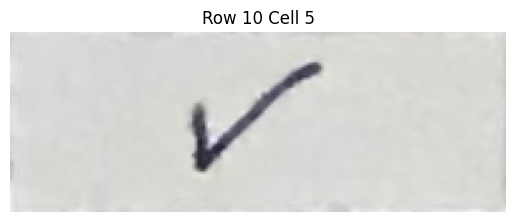

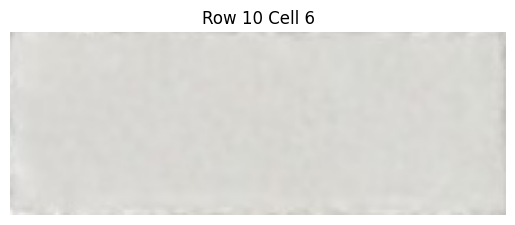

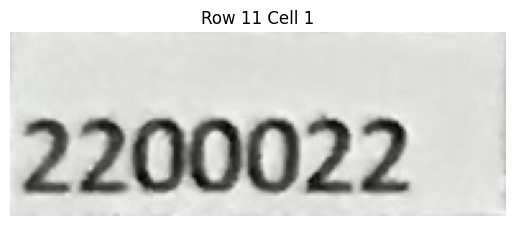

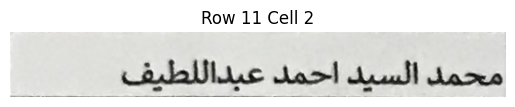

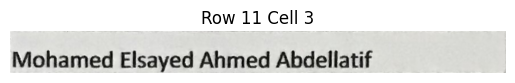

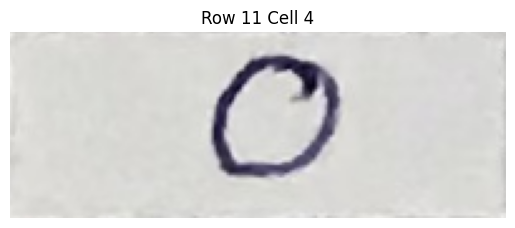

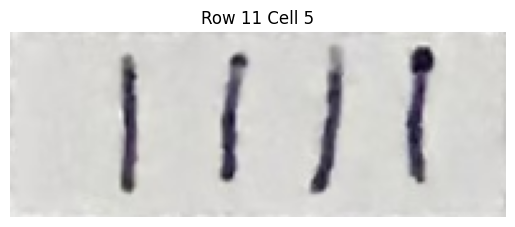

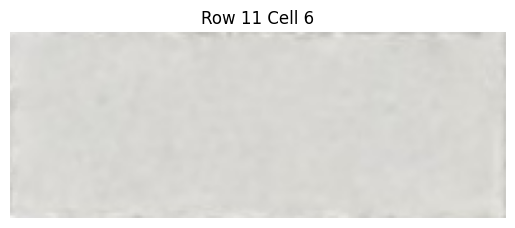

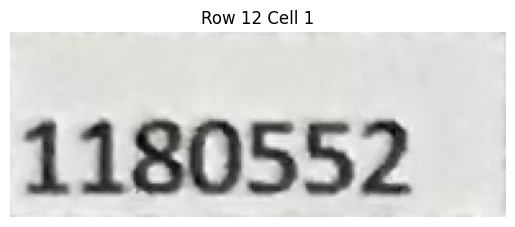

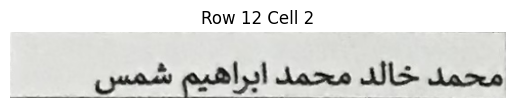

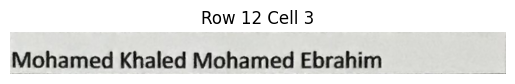

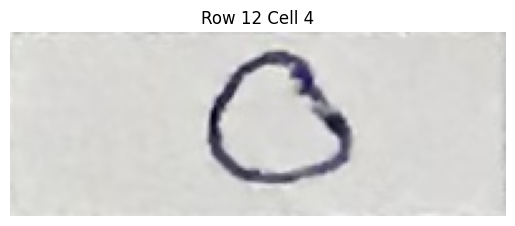

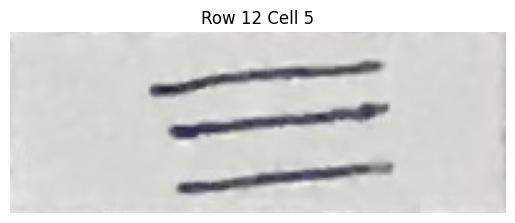

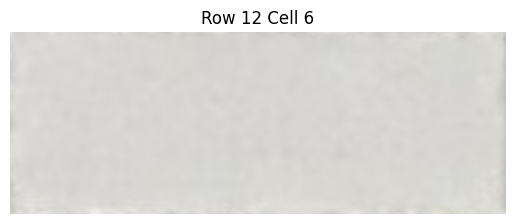

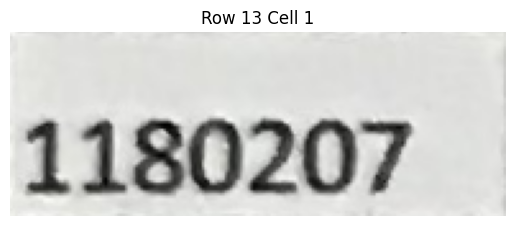

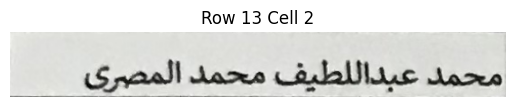

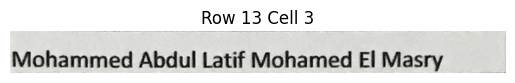

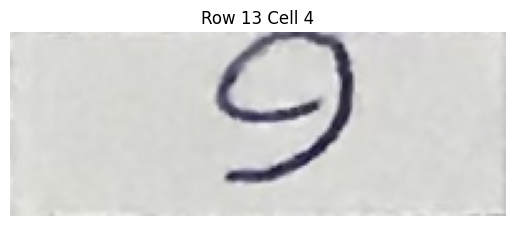

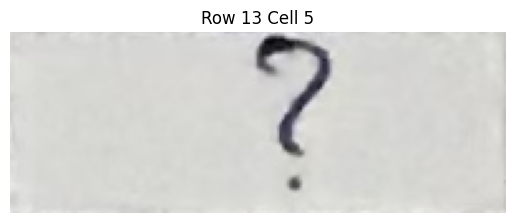

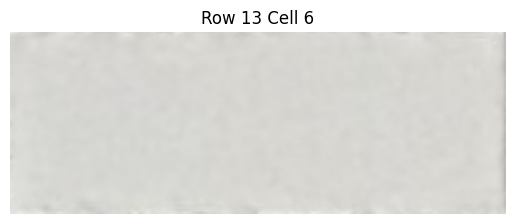

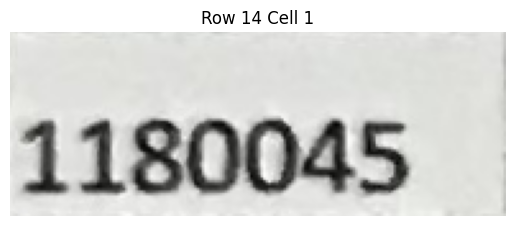

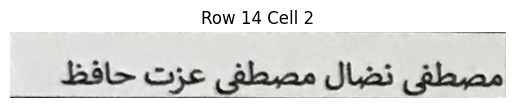

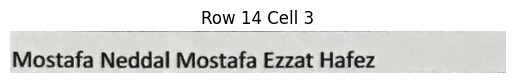

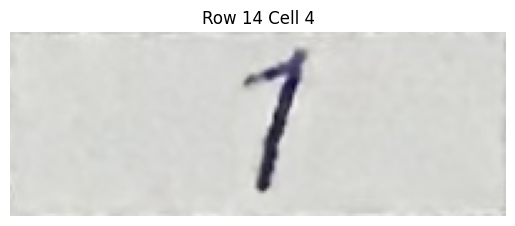

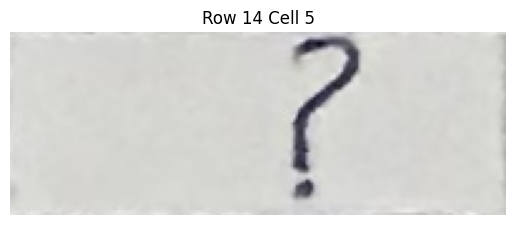

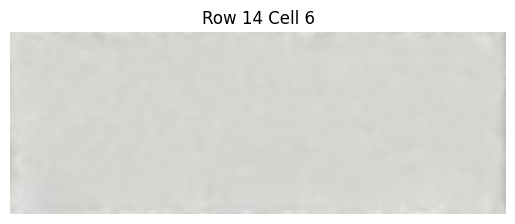

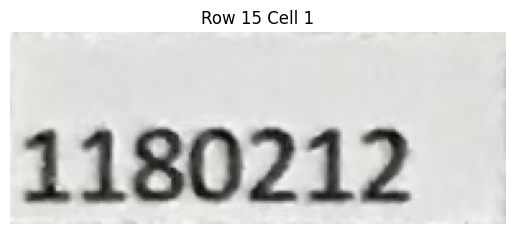

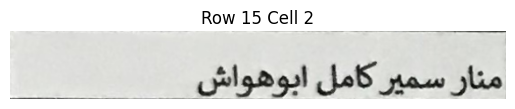

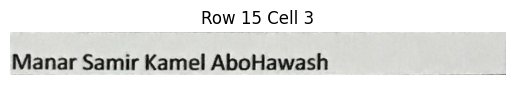

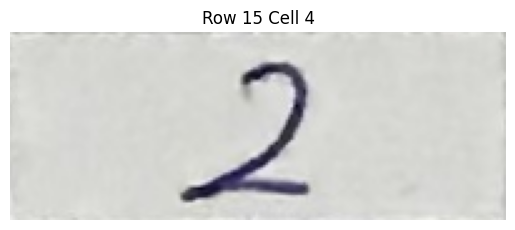

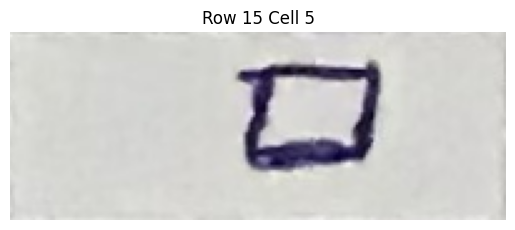

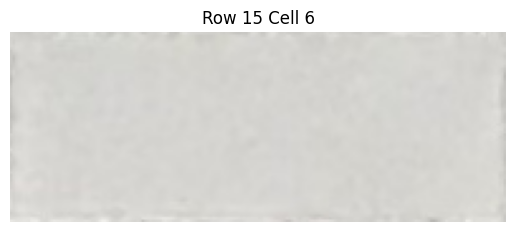

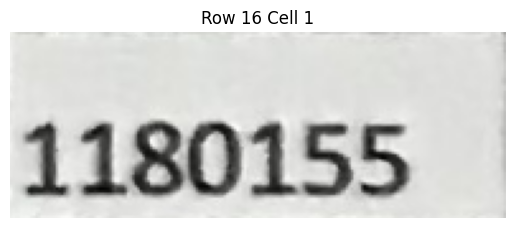

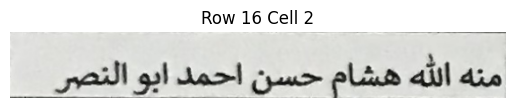

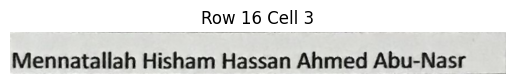

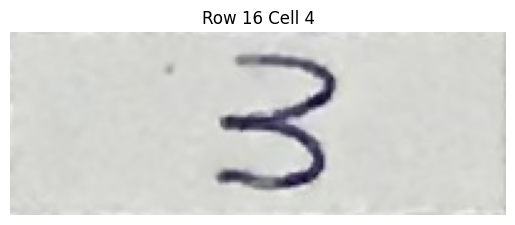

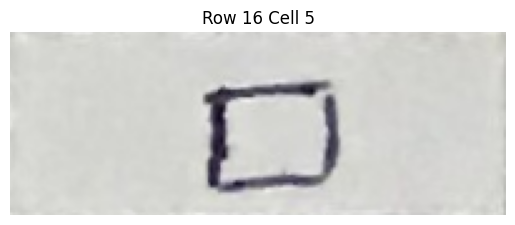

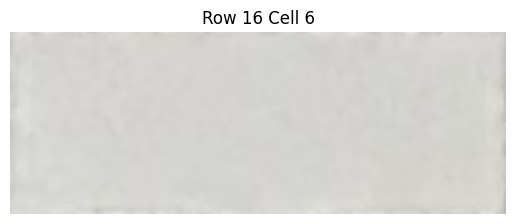

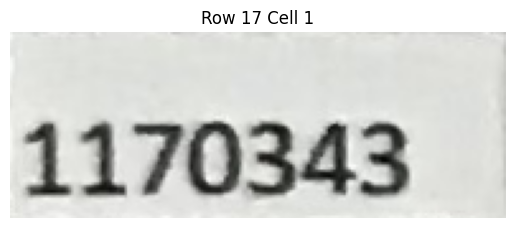

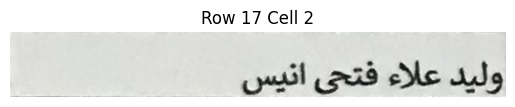

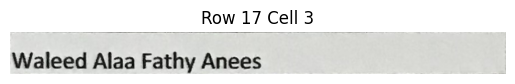

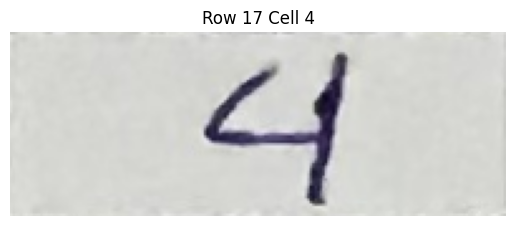

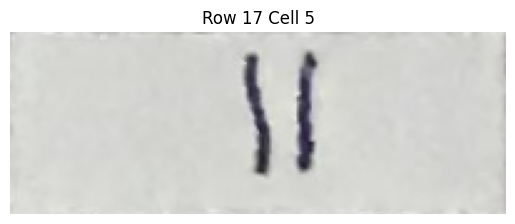

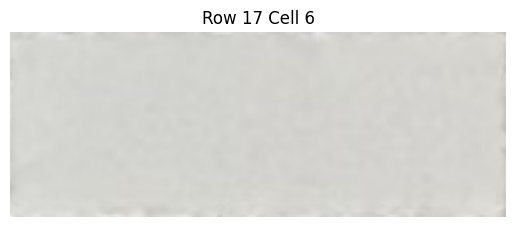

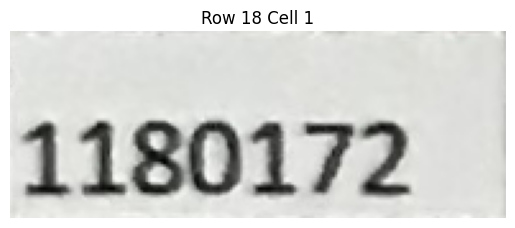

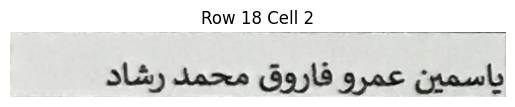

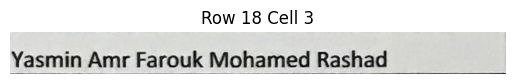

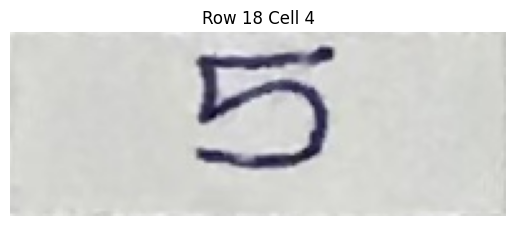

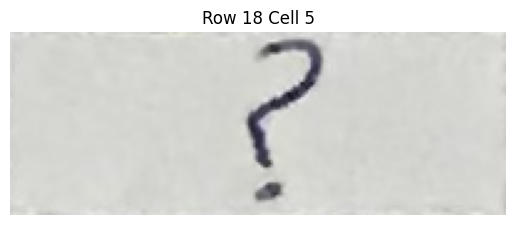

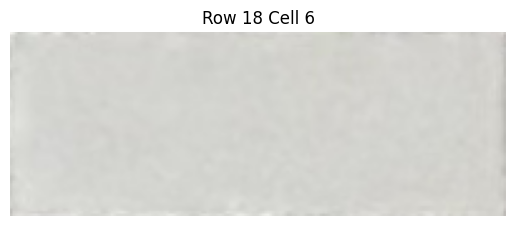

Total Rows Detected: 18
Row 1: 6 cells
Row 2: 6 cells
Row 3: 6 cells
Row 4: 6 cells
Row 5: 6 cells
Row 6: 6 cells
Row 7: 6 cells
Row 8: 6 cells
Row 9: 6 cells
Row 10: 6 cells
Row 11: 6 cells
Row 12: 6 cells
Row 13: 6 cells
Row 14: 6 cells
Row 15: 6 cells
Row 16: 6 cells
Row 17: 6 cells
Row 18: 6 cells


In [3]:
import cv2 as cv
import numpy as np
from utils import *
from tableExtraction import *

cellWidth = 30
cellHeight = 20

# Load image and extract table
image = cv.imread(images[0])
image = extractTable(images[0])
img_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Thresholding and invert (lines = white)
_, img_bin = cv.threshold(img_gray, 128, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)
img_bin = cv.bitwise_not(img_bin)

# Detect vertical lines
kernel_length_v = img_gray.shape[1] // 120
vertical_kernel = cv.getStructuringElement(cv.MORPH_RECT, (1, kernel_length_v))
temp_img_v = cv.erode(img_bin, vertical_kernel, iterations=5)
vertical_lines = cv.dilate(temp_img_v, vertical_kernel, iterations=5)

# Detect horizontal lines
kernel_length_h = img_gray.shape[0] // 40
horizontal_kernel = cv.getStructuringElement(cv.MORPH_RECT, (kernel_length_h, 1))
temp_img_h = cv.erode(img_bin, horizontal_kernel, iterations=5)
horizontal_lines = cv.dilate(temp_img_h, horizontal_kernel, iterations=5)

# Combine lines to get table skeleton
table_segment = cv.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
table_segment = cv.erode(cv.bitwise_not(table_segment), kernel, iterations=2)
_, table_segment = cv.threshold(table_segment, 0, 255, cv.THRESH_OTSU)

# Find contours
contours, _ = cv.findContours(table_segment, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Filter valid cells
cells = []
for c in contours:
    x, y, w, h = cv.boundingRect(c)
    if w >= cellWidth and h >= cellHeight:
        cells.append((x, y, w, h))

# Sort cells top → bottom
cells = sorted(cells, key=lambda b: b[1])

# Group cells into rows based on y-coordinate
rows = []
current_row = [cells[0]]
for cell in cells[1:]:
    if abs(cell[1] - current_row[-1][1]) < 20:  # tolerance for same row
        current_row.append(cell)
    else:
        rows.append(sorted(current_row, key=lambda b: b[0]))
        current_row = [cell]
rows.append(sorted(current_row, key=lambda b: b[0]))

# Visualize rows on image
output_img = image.copy()
colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]
for i, row in enumerate(rows):
    for (x, y, w, h) in row:
        cv.rectangle(output_img, (x, y), (x+w, y+h), colors[i % 4], 2)

show_images([output_img], titles=["Cells Highlighted"])

# Show each cell individually
for i, row in enumerate(rows):
    for j, (x, y, w, h) in enumerate(row):
        cell_img = image[y:y+h, x:x+w]
        show_images([cell_img], titles=[f"Row {i+1} Cell {j+1}"])

# ------------------ Print rows and cell count ------------------
print(f"Total Rows Detected: {len(rows)}")
for i, row in enumerate(rows):
    print(f"Row {i+1}: {len(row)} cells")
